In [1]:
import torch 
from torch import nn
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
class Featuremap_log:
    def __init__(self, eps):
        self.eps = eps
    def __call__(self,x):
        try:
            #c = torch.abs(torch.min(x[x <= 0])) + self.eps
            c = self.eps
        except RuntimeError:
            c = self.eps ### No values < 0
        return torch.log(x + c) - torch.log(1 + c / x)
    def m(self,n):
        return n

class Featuremap_exp:
    def __init__(self):
        pass
    def __call__(self,x):
        return torch.exp(torch.nan_to_num(x, nan=-float('inf')))
    def m(self,n):
        return n

Test = Featuremap_log(eps = 0.1)
vec = torch.randn(100,100)
print(Test(vec))
print(vec)
#weird_values = nn.Linear(100, 1)
#weird_values(Test(torch.zeros(100,100)))
print(torch.exp((2.3*(torch.log(torch.ones(10) * 8) + (1j*torch.pi*2)))))
w = 1.2
print(torch.exp(w * (torch.log(torch.ones(1) *8 * torch.exp(2j * torch.pi * torch.ones(1))))))
print(torch.exp(2j * torch.pi * torch.ones(1)))

tensor([[ 0.6456, -1.0896,     nan,  ...,  0.3581, -3.8620,     nan],
        [ 0.6336,     nan,  0.6285,  ..., -0.1351,     nan, -0.3115],
        [    nan,     nan, -1.0501,  ...,     nan,     nan, -0.0667],
        ...,
        [    nan,     nan,     nan,  ..., -0.4928,     nan,     nan],
        [    nan,     nan,  0.6994,  ..., -2.6530, -0.0345,     nan],
        [-1.3103,     nan,     nan,  ...,     nan, -1.6898,     nan]])
tensor([[ 1.9071,  0.3363, -0.1259,  ...,  1.4306,  0.0210, -1.4867],
        [ 1.8844, -1.9340,  1.8748,  ...,  0.8737, -0.3316,  0.7324],
        [-1.1604, -0.2361,  0.3499,  ..., -1.1025, -1.0614,  0.9355],
        ...,
        [-1.1460, -0.0036, -0.2378,  ...,  0.6109, -0.4083, -0.3653],
        [-0.3151, -0.0853,  2.0126,  ...,  0.0704,  0.9661, -0.4864],
        [ 0.2697, -0.5637, -0.4072,  ..., -1.4843,  0.1845, -1.3372]])
tensor([-36.9054+113.5830j, -36.9054+113.5830j, -36.9054+113.5830j,
        -36.9054+113.5830j, -36.9054+113.5830j, -36.9054+113.583

In [421]:
class Symbolic_Featuremap:
    def __init__(self):
        pass
    def __call__(self,x):
        contains_nan_exp = torch.isnan(torch.exp(x)).any()
        contains_inf_exp = torch.isinf(torch.exp(x)).any()
        contains_nan_log = torch.isnan(torch.log(x)).any()
        contains_inf_log = torch.isinf(torch.log(x)).any()
        #print("log: inf:" ,contains_inf_log,"nan:" ,contains_nan_log)
        #print("exp: inf:" ,contains_inf_exp,"nan:" ,contains_nan_exp)
        #if contains_inf_exp.item():
        #    print(x[torch.exp(x) == float('inf')])
        #if (x.real > 88).any() or (x.imag > 88).any():
        #    torch.hstack((torch.ones((x.shape[0],1)).to(torch.complex64), torch.log(x), torch.ones(x.shape) * 1e30j))
        #print(x)
        #if contains_inf_log.item() or contains_nan_log.item():
            #print("log is dead:")
            #print(x[torch.isinf(torch.log(x))], "inf")
            #print(x[torch.isnan(torch.log(x))], "nan")
        #    return torch.hstack((torch.ones((x.shape[0],1)).to(torch.complex64),  torch.ones(x.shape) * 1e30j, torch.ones(x.shape) * 1e30j))

        #if contains_inf_exp.item() or contains_nan_exp.item():
            #print("exp is dead")
            #print(x[torch.isinf(torch.exp(x))], "inf")
            #print(x[torch.isnan(torch.exp(x))], "nan")
        #    return torch.hstack((torch.ones((x.shape[0],1)).to(torch.complex64), torch.log(x), torch.ones(x.shape) * 1e30j))
        return torch.hstack((torch.ones((x.shape[0],1)).to(torch.complex64), torch.log(x), torch.exp(x)))
        #return torch.hstack((torch.ones((x.shape[0],1)).to(torch.complex64), torch.log(torch.clamp(torch.abs(x), min=0.1)) + 1j * torch.angle(x), torch.exp(torch.clamp(x.real, min=-709, max=709)) * (torch.cos(x.imag) + 1j * torch.sin(x.imag))))
    def m(self,n):
        return 2*n + 1
        
    

In [457]:
class Symbolics:
    def __init__(self, symbols = [torch.sin, torch.cos, torch.log]):
        self.symbols = symbols
        self.num_constants = 5
        self.fc1 = nn.Linear(1,self.num_constants, bias = False, dtype = torch.complex64)
    def constants(self,x):
        ## x.shape = [Batch_size, 1]
        # learns constants for 
        return self.fc1(x)

    def __call__(self,x):
        return torch.hstack([self.constants(torch.ones((x.shape[0],1)).to(torch.complex64)), x] + [func(x) for func in self.symbols])
    def m(self, n):
        return len(self.symbols) * n + 1

class Featuremap_log:
    def __init__(self, eps):
        self.eps = eps
    def __call__(self,x):
        return torch.log(x)
    def m(self,n):
        return n

class Featuremap_exp:
    def __init__(self):
        pass
    def __call__(self,x):
        return torch.exp(torch.nan_to_num(x, nan=-float('inf')))
    def m(self,n):
        return n

In [459]:
class Symbolic_Layer(nn.Module):
    def __init__(self):
        super(Symbolic_Layer, self).__init__()
        n = 100
        m = 1
        N = 32
        self.map_1 = Symbolics()
        self.map_2 = Featuremap_log(eps = 1)
        self.map_3 = Featuremap_exp()
        self.fc1 = nn.Linear(self.map_1.m(n), N, bias = False, dtype = torch.complex64)
        self.fc2 = nn.Linear(self.map_2.m(n), N, bias = False, dtype = torch.complex64)
        self.fc3 = nn.Linear(self.map_3.m(N), m, bias = False, dtype = torch.complex64)
        
    def forward(self,x):
        t_1 = self.map_1(x)
        f_1 = self.fc1(t_1)
        t_2 = self.map_2(f_1)
        f_2 = self.fc2(t_2)
        t_3 = self.map_3(f_2)
        f_3 = self.fc3(t_3)
        return f_3

Net = Symbolic_Layer()
Net(torch.randn(16,100) + torch.zeros(16,100) * 1j)

    


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x405 and 301x32)

In [ ]:
#### arccos(sqrt(x**2 + y**2)) = -i ln(||x|| + i*(sqrt(1 - ||x||**2)))

In [166]:
m = Symbolic_Featuremap()
print(m(torch.tensor([[0+1j, 700+88j]])))
print(torch.log(torch.tensor([700+88j])))

tensor([[1.0000+0.0000e+00j, 0.0000+1.5708e+00j, 6.5589+1.2506e-01j,
         0.0000+1.0000e+30j, 0.0000+1.0000e+30j]])
tensor([6.5589+0.1251j])


In [152]:
tensor = 8 * torch.ones(1) * torch.exp(1j*torch.pi * torch.ones(1))
tensor2 = 1.92 * torch.ones(1) * torch.exp(2j*torch.pi * torch.ones(1))
print(tensor)
print(torch.exp(torch.log(tensor) - torch.log(tensor2)))

tensor([-8.-6.9938e-07j])
tensor([-4.1667+3.6426e-07j])


In [153]:
x = torch.randn(100,100)
torch.log(torch.tensor(0, dtype = torch.complex64))

tensor(-inf+0.j)

In [154]:
import cmath
a = 1.9
print(cmath.exp(2j*cmath.pi))
print(cmath.exp(a* (cmath.log(8 * cmath.exp(2j*cmath.pi)))))
print(cmath.exp(a* (cmath.log(8) + 2j*cmath.pi)))

(1-2.4492935982947064e-16j)
(51.984153366799056-2.4191646270273515e-14j)
(42.05606351193406-30.555518701914618j)


In [155]:
class Featuremap_trig():
    def __init__(self):
        pass
    def __call__(self, x):
        #exp_ix = torch.exp(1j * x)
        #exp_neg_ix = torch.exp(-1j * x)
        return torch.hstack((torch.cos(x), torch.sin(x)))
    def m(self,n):
        return 2 * n

In [156]:
class Net_trig(nn.Module):

    def __init__(self):
        super(Net_trig, self).__init__()
        n = 2
        m = 1
        N_1 = 512
        N_2 = 512
        N_3 = 512
        m_1 = 512
        m_2 = 128
        self.map_1 = Featuremap_log(eps = 0.1)
        self.map_2 = Featuremap_exp()
        self.map_3 = Featuremap_trig()
        self.fc1 = nn.Linear(self.map_1.m(n), N_1)
        self.fc2 = nn.Linear(self.map_2.m(N_1), m_1)
        self.fc3 = nn.Linear(m_1, N_2)
        #self.fc2 = nn.Linear(self.map.m(N), m, dtype=torch.complex64)
        self.fc4 = nn.Linear(self.map_3.m(N_2), m)
        self.fc5 = nn.Linear(m_2, N_3)
        #self.fc2 = nn.Linear(self.map.m(N), m, dtype=torch.complex64)
        self.fc6 = nn.Linear(self.map_3.m(N_3), m)

        #self.f_test = nn.Linear(n,N_2)

    def forward(self, x):
        t_1 = self.map_1(x)
        f_1 = self.fc1(t_1)
        t_2 = self.map_2(f_1)
        f_2 = self.fc2(t_2)
        f_3 = self.fc3(f_2)
        #f_2 = self.f_test(x)
        t_3 = self.map_3(f_3)
        f_4 = self.fc4(t_3)
        return f_4
        f_5 = self.fc5(f_4)
        t_5 = self.map_3(f_5)
        f_6 = self.fc6(t_5)
        return f_6

    def plot_model(self):
        x = np.linspace(0, 1, 50)  # Example range for x
        y = np.linspace(0, 1, 50)  # Example range for y

        # Generate meshgrid
        X, Y = np.meshgrid(x, y)

        # Flatten the two meshgrid arrays
        X_flat = X.flatten()
        Y_flat = Y.flatten()

        mesh_data = np.stack((X_flat, Y_flat), axis=1)
        output = self(torch.tensor(mesh_data, dtype = torch.float32))
        Z = output.reshape(50, 50)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis', edgecolor='none')
        ax.set_title('3D Surface Plot of f(x, y)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('f(X, Y)')

        # Show the plot
        plt.show()

model = Net_trig()
x = model(torch.rand([16,2]))
print(x)


tensor([[-0.2628],
        [-0.2786],
        [-0.2675],
        [-0.2326],
        [-0.2100],
        [-0.2947],
        [-0.2376],
        [-0.2504],
        [-0.2163],
        [-0.2618],
        [-0.3661],
        [-0.5956],
        [-0.2658],
        [-0.2161],
        [-0.2915],
        [-0.2819]], grad_fn=<AddmmBackward0>)


In [157]:
class BSplineBasis(torch.nn.Module):
    def __init__(self, order, grid_size, start=0.0, end=1.0):
        super(BSplineBasis, self).__init__()
        self.order = order
        self.grid_size = grid_size
        self.knots = torch.linspace(start, end, grid_size + 1 + order)  # Knots including extra ones for boundary conditions
    
    def basis_function(self, x, i, k, t):
        """Recursively defines the basis spline B_{i,k}(x)."""
        if k == 0:  # Order 0 (piecewise constant)
            return ((t[i] <= x) & (x < t[i+1])).float()
        else:
            left_term = ((x - t[i]) / (t[i+k] - t[i])) * self.basis_function(x, i, k-1, t)
            right_term = ((t[i+k+1] - x) / (t[i+k+1] - t[i+1])) * self.basis_function(x, i+1, k-1, t)
            return left_term.nan_to_num(0.0) + right_term.nan_to_num(0.0)

    def forward(self, x):
        """
        Compute the spline basis functions for input `x`.
        `x` should be a tensor of shape [batch_size,].
        """
        B = torch.stack([self.basis_function(x, i, self.order, self.knots) for i in range(self.grid_size)], dim=-1)
        return B


# Example usage:
order = 3  # cubic splines
grid_size = 5  # number of internal knots (excluding boundary)

# Create a tensor of inputs (x values)
x = torch.linspace(0, 1, 100)  # 100 points between 0 and 1

# Initialize B-spline basis
bspline_basis = BSplineBasis(order=order, grid_size=grid_size)

# Forward pass: compute the B-spline basis functions at input points `x`
B = bspline_basis(x)

# Print the shape of the output (it should be [100, grid_size])
print(B.shape)


torch.Size([100, 5])


In [422]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        n = 2
        m = 1
        N = 8
        self.map = Symbolic_Featuremap()
        self.fc1 = nn.Linear(self.map.m(n), N, bias = False, dtype = torch.complex64)
        self.fc2 = nn.Linear(self.map.m(N), N, bias = False, dtype = torch.complex64)
        self.fc3 = nn.Linear(self.map.m(N), m, bias = True, dtype = torch.complex64)
        #self.map_1 = Featuremap_log(eps = 0.1)
        #self.map_2 = Featuremap_exp()
        #self.fc1 = nn.Linear(self.map_1.m(n), N)
        #self.fc2 = nn.Linear(self.map_2.m(N), m)

    def forward(self, x):
        t_1 = self.map(x)
        f_1 = self.fc1(t_1)
        t_2 = self.map(f_1)
        f_2 = self.fc2(t_2)
        t_3 = self.map(f_2)
        f_3 = self.fc3(t_3)
        return f_3
        #t_1 = self.map_1(x)
        #f_1 = self.fc1(t_1)
        #t_2 = self.map_2(f_1)
        #f_2 = self.fc2(t_2)
        return f_2

    def plot_model(self):
        x = np.linspace(0, 1, 50)  # Example range for x
        y = np.linspace(0, 1, 50)  # Example range for y

        # Generate meshgrid
        X, Y = np.meshgrid(x, y)

        # Flatten the two meshgrid arrays
        X_flat = X.flatten()
        Y_flat = Y.flatten()

        mesh_data = np.stack((X_flat, Y_flat), axis=1)
        output = self(torch.tensor(mesh_data, dtype = torch.complex64))
        Z = output.real.reshape(50, 50)

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z.detach().numpy(), cmap='viridis', edgecolor='none')
        ax.set_title('3D Surface Plot of f(x, y)')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('f(X, Y)')

        # Show the plot
        plt.show()



#m = Symbolic_Featuremap()
#o = m(torch.randn(16,2).to(torch.complex64))
#print(o.shape)
model = Net()
#print(model(x_batch + 1j* torch.zeros(x_batch.shape)))
#tensor = torch.randn(124,2) + 1j * torch.zeros(124,2)
#model(tensor)
#print(tensor)
#print(torch.exp(tensor))
#print(torch.max(torch.abs(tensor)))


In [184]:
torch.log(torch.tensor([-0.8660 + 0j, 0.3329+0j]))

tensor([-0.1439+3.1416j, -1.0999+0.0000j])

In [432]:
def train(model, dataset, epochs):
    loss_fn = torch.nn.MSELoss()
    optimizer = optim.RAdam(model.parameters(), lr=0.001)#, weight_decay=10e-2)
    loss_nd = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = 0.
        for id_batch, (x_batch, y_batch) in enumerate(dataloader):
            optimizer.zero_grad()
            out = model(x_batch.to(torch.complex64))
            #print(out.imag)
            loss = loss_fn(out.real, y_batch) + torch.norm(out.imag,2) #
            #print(torch.norm(out.imag))
            train_loss += loss.item()
            for p in model.parameters():
                print(torch.norm(p,2))
                if torch.isnan(torch.norm(p,2)).any():
                    print(p)
                    print(out)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        loss_nd[epoch] = train_loss
    return model, loss_nd

In [426]:
x_batch = torch.randn([16,2])
model(x_batch + 1j* torch.zeros(x_batch.shape))


tensor([[-1.9852-1.2405j],
        [-1.2671-1.7216j],
        [ 4.6526+0.1202j],
        [-4.3840+0.7046j],
        [-2.2614-1.2934j],
        [-2.6257-2.2414j],
        [ 9.5323-6.2263j],
        [-5.1606-1.4292j],
        [-1.1687+0.4993j],
        [-0.7888+0.0393j],
        [-0.4888+0.4579j],
        [-9.1553-2.6639j],
        [-0.6487-7.0547j],
        [-1.2184+0.2425j],
        [-2.6982-2.7899j],
        [-5.7972+8.6558j]], grad_fn=<AddmmBackward0>)

In [427]:
from torch.utils.data import DataLoader, TensorDataset

def create_dataloader(func, input_dim, data_length, batch_size=16, shuffle=True):
    inputs = torch.rand(data_length, input_dim) # Gaussian t.f 0 w.p 0
    #inputs[inputs > 0] += 1
    #inputs[inputs < 0] -= 1
    #inputs[inputs < -1] = inputs[inputs < -1] + 3
    #print(torch.max(inputs))
    #print(torch.min(inputs))
    #print(inputs.shape)
    #print(torch.isclose(,x0))
    outputs = func(inputs).unsqueeze(1)
    dataset = TensorDataset(inputs, outputs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [428]:

model = Net()
for p in model.parameters():
    print(type(p))

<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>


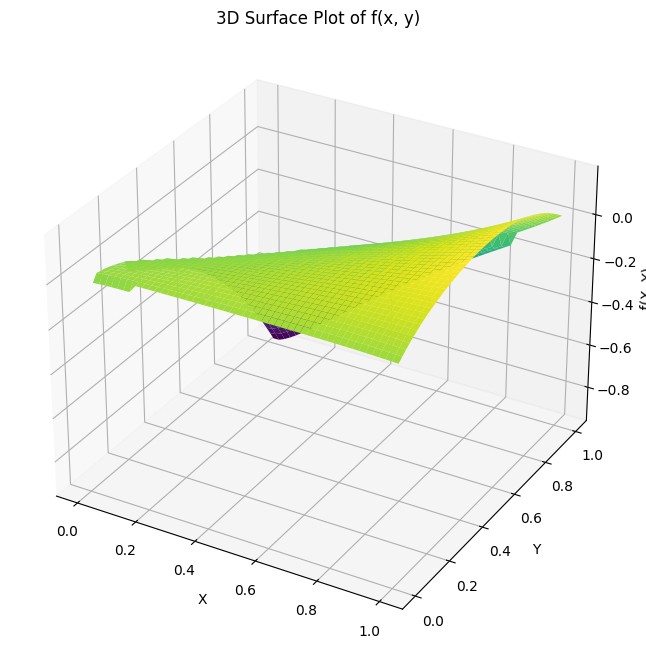

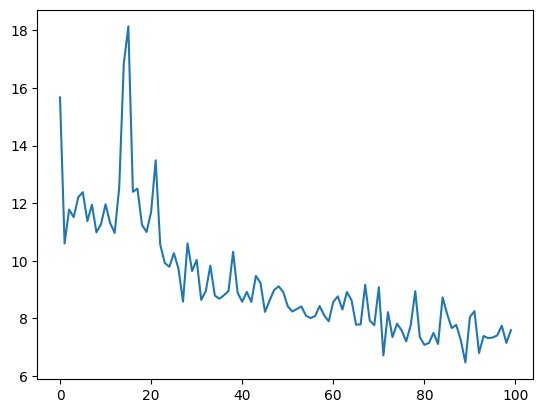

In [431]:
#f = lambda X: torch.exp(torch.sin(X[:,0]**2) + X[:,1]**2)
#f = lambda X:torch.sin(X[:,0] * 100)*torch.sin(X[:,1] * 100)


f = lambda X: X[:,0] * X[:,1] - X[:,1]**2
dataloader = create_dataloader(f, input_dim =2, data_length=10000)
model, loss = train(model, dataloader, 100)
model.plot_model()
plt.plot(loss)
plt.show()

In [194]:
model(torch.randn(16,2) + 1j * torch.randn(16,2))
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj]],
       requires_grad=True)
Parameter containing:
tensor([[nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
         nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
         nan+nanj, nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, n

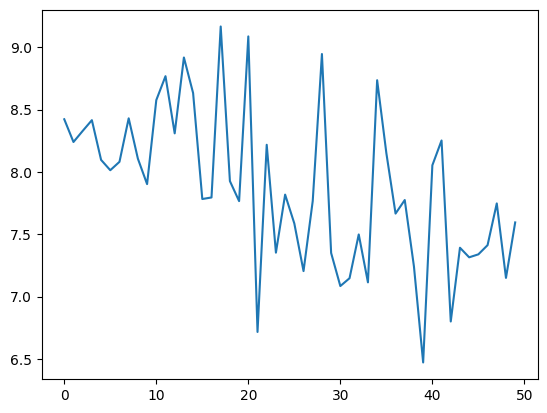

In [433]:
plt.plot(loss[50:])
plt.show()

In [19]:
f = lambda X: np.exp(np.sin(X[:,0]**2) + X[:,1]**2)

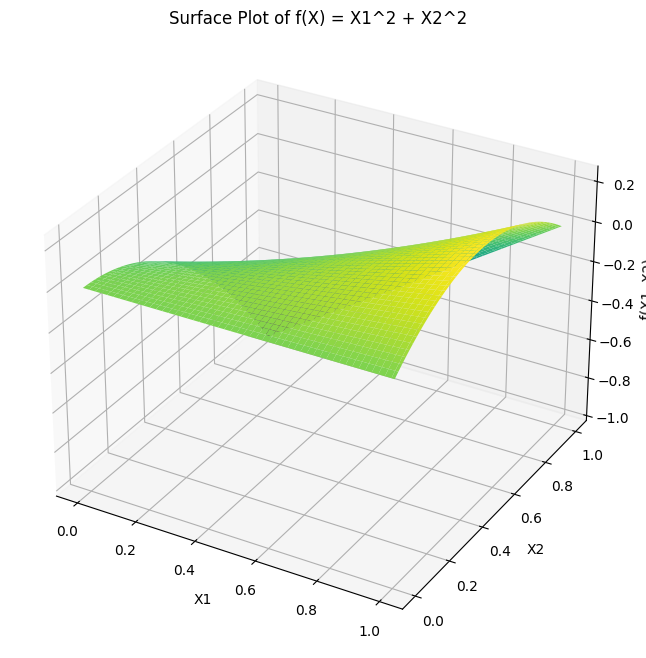

In [417]:
f = lambda X:np.sin(X[:,0] * 100)*np.sin(X[:,1] * 100)
f = lambda X: X[:,0] * X[:,1] - X[:,1]**2

x = np.linspace(0, 1, 100)  # Change the range as needed
y = np.linspace(0, 1, 100)
X1, X2 = np.meshgrid(x, y)  # Create a meshgrid for x and y

# Stack the grid points and evaluate the function
Z = f(np.column_stack((X1.ravel(), X2.ravel())))  # Evaluate f on the meshgrid
Z = Z.reshape(X1.shape)  # Reshape back to 2D for plotting

# Plot the surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('f(X1, X2)')
ax.set_title('Surface Plot of f(X) = X1^2 + X2^2')

# Show the plot
plt.show()